## Overview ##
This Notebook is built on Kaggle's Natural Language Processing with Disaster Tweets competition (https://www.kaggle.com/competitions/nlp-getting-started/overview).  The goal is to predice if the tweet in the sample date predicts if the tweet is about a natural disaster.

The overall approach will be to start by importing the required python packages and do a quick explority data analysis.  Then it will prepare the data for modeling by addressing nulls, cleaning the text, and tokenizing the text.  The data will then will be split 80-20 for a train-validation.  (Kaggle has its own test dataset for final model testing).  The model build will be an RNN relying mainly on LSTM.  Finally, will look at classic classification metrics like accuracy and ROC AUC, while checking for overfitting by looking at loss curve.

For the model, I manually re-ran the modeling section with multiple scenerios, such as learning rate, number of nodes, and dropout.  Then picked a model with a good accuracy and loss curve.  

Finally, the kaggle test data set is predicted with the final model, which involves same data transformations as with the training dataset, predicting results with the model and creating a kaggle submission file.

In [1]:
#Import python packages
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string

from nltk.corpus import stopwords

from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, LSTM, Embedding, GRU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve

## EDA ##
used to get a quick understanding of the data.

In [2]:
train_df = pd.read_csv('input/nlp-getting-started/train.csv')
train_df.head(10)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1


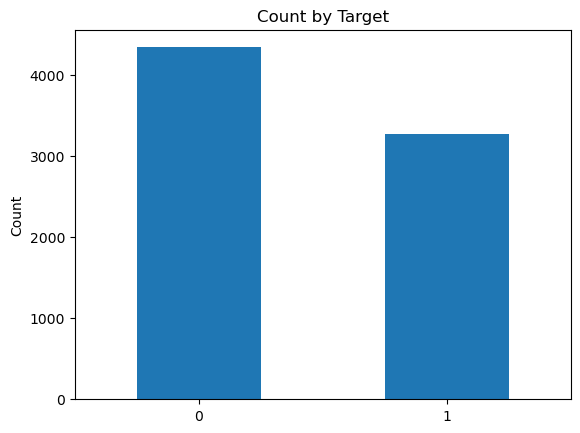

In [3]:
train_df['target'].value_counts().plot(kind='bar')
plt.ylabel('Count')
plt.title('Count by Target')
plt.xticks(rotation=0)
plt.show()

In [4]:
train_df.isnull().sum()
#shows large number of nulls in location and some with keyword variables

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [5]:
train_df['location'].value_counts()

USA                    104
New York                71
United States           50
London                  45
Canada                  29
                      ... 
MontrÌ©al, QuÌ©bec       1
Montreal                 1
ÌÏT: 6.4682,3.18287      1
Live4Heed??              1
Lincoln                  1
Name: location, Length: 3341, dtype: int64

In [6]:
train_df['keyword'].value_counts()

fatalities               45
deluge                   42
armageddon               42
sinking                  41
damage                   41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: keyword, Length: 221, dtype: int64

## Data Cleaing and Prep ##
using this section to clean up the text for modelling.  This includes replacing nulls with blanks, cleaning special characters/html, and removing stopwords.  Then the data will be tokenized, so the that words can be vectorized for modeling purposes. Lastly, the 20% split of the data will be done for the training and validation data sets.

In [7]:
#Will fill nulls with blanks.  For keywords, this makes sense due to low number of nulls.
#Might revist this for location, since about a third fo the locations are missing
train_df = train_df.replace(np.nan, '')
train_df.head()

,id,keyword,location,text,target
0,1,,,Our Deeds are the Reason of this #earthquake M...,1
1,4,,,Forest fire near La Ronge Sask. Canada,1
2,5,,,All residents asked to 'shelter in place' are ...,1
3,6,,,"13,000 people receive #wildfires evacuation or...",1
4,7,,,Just got sent this photo from Ruby #Alaska as ...,1


In [8]:
# Special thanks to https://www.kaggle.com/tanulsingh077 for this function
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub(
        'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', 
        '', 
        text
    )
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    
    return text

def filter_words(text):
    filtered_words = [ word for word in text.split(' ') if word not in stopwords.words('english')]
    return filtered_words

In [96]:
import nltk
nltk.download('stopwords')

train_df['text'] = train_df['text'].apply(lambda x: clean_text(x))
train_df['text'] = train_df['text'].apply(lambda x: filter_words(x))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rkiki\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
#max_nr_words = 5000
tokenizer = Tokenizer(5000)
tokenizer.fit_on_texts(train_df['text'])
sequences = tokenizer.texts_to_sequences(train_df['text'])

In [12]:
tot_tokens = len(tokenizer.word_index)

In [13]:
#len(sequences[1])
max_seq = 0
for i in range(len(sequences)):
    if len(sequences[i]) > max_seq:
        max_seq = len(sequences[i])
print(max_seq)

51


In [14]:
padded_seq = pad_sequences(sequences, max_seq)

In [16]:
#Create a 20% validation data set for testing
X = padded_seq
y = train_df['target']

x_train, x_val, y_train, y_val = train_test_split(X,y, test_size=0.2, random_state=25)

In [17]:
y_train.value_counts()

0    3495
1    2595
Name: target, dtype: int64

In [18]:
y_val.value_counts()

0    847
1    676
Name: target, dtype: int64

In [19]:
print(x_train.shape)
print(x_val.shape)

(6090, 51)
(1523, 51)


## Model ##
This section will create an RNN model, relying on embedding and LSTM.  The model was manually iterated through to get solid results.  This section also has the model results, including accuracy and loss.

In [144]:
model = Sequential()
model.add(Embedding(tot_tokens+1, 16, input_length=max_seq))
model.add(Dropout(0.2))
model.add(LSTM(128))
model.add(Dropout(0.2))
model.add((Dense(1, activation='sigmoid')))

model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_16 (Embedding)    (None, 51, 16)            267296    
                                                                 
 dropout_21 (Dropout)        (None, 51, 16)            0         
                                                                 
 lstm_18 (LSTM)              (None, 128)               74240     
                                                                 
 dropout_22 (Dropout)        (None, 128)               0         
                                                                 
 dense_14 (Dense)            (None, 1)                 129       
                                                                 
Total params: 341,665
Trainable params: 341,665
Non-trainable params: 0
_________________________________________________________________


In [145]:
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [146]:

hist = model.fit(x=x_train, y=y_train, epochs=5, validation_data=(x_val, y_val))

Epoch 1/5
191/191 [==============================] - 5s 16ms/step - loss: 0.6827 - accuracy: 0.5700 - val_loss: 0.6805 - val_accuracy: 0.5561
Epoch 2/5
191/191 [==============================] - 3s 13ms/step - loss: 0.6666 - accuracy: 0.5842 - val_loss: 0.6558 - val_accuracy: 0.6349
Epoch 3/5
191/191 [==============================] - 2s 13ms/step - loss: 0.6205 - accuracy: 0.6831 - val_loss: 0.6058 - val_accuracy: 0.6829
Epoch 4/5
191/191 [==============================] - 2s 12ms/step - loss: 0.5392 - accuracy: 0.7532 - val_loss: 0.5264 - val_accuracy: 0.7538
Epoch 5/5
191/191 [==============================] - 2s 12ms/step - loss: 0.4364 - accuracy: 0.8082 - val_loss: 0.4877 - val_accuracy: 0.7663


In [147]:
pred = model.predict(x_val)
pred_binary = (pred > 0.5).astype(int).flatten()
y_pred = pred_binary[:len(y_val)]

48/48 [==============================] - 1s 4ms/step


In [148]:
#check standard classification metrics
accuracy = accuracy_score(y_val, y_pred)
print(f'Accuracy: {accuracy}')
precision = precision_score(y_val, y_pred)
print(f'Precision: {precision}')
recall = recall_score(y_val, y_pred)
print(f'Recall: {recall}')
f1 = f1_score(y_val, y_pred)
print(f'F1: {f1}')
roc_auc = roc_auc_score(y_val, y_pred)
print(f'ROC AUC: {roc_auc}')

Accuracy: 0.7662508207485227
Precision: 0.8619909502262444
Recall: 0.5636094674556213
F1: 0.6815742397137746
ROC AUC: 0.7457952886274565


In [149]:
#set up dataframe of model results for overfitting plots
hist = pd.DataFrame(hist.history)
hist.head(5)

,loss,accuracy,val_loss,val_accuracy
0,0.682681,0.569951,0.680482,0.556139
1,0.666647,0.584236,0.655757,0.634931
2,0.620549,0.683087,0.605791,0.682863
3,0.539244,0.753202,0.526377,0.753775
4,0.436377,0.808210,0.487699,0.766251


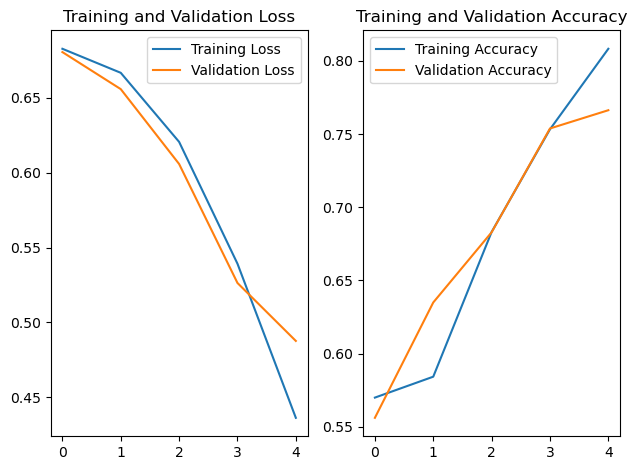

In [150]:
#check for overfitting

#Plot the loss metric
plt.subplot(1, 2, 1)
plt.plot(hist['loss'], label='Training Loss')
plt.plot(hist['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(hist['accuracy'], label='Training Accuracy')
plt.plot(hist['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.tight_layout()
plt.show()

## Results  ##
For this model, I ran mutliple tests changing the number of epochs, learning curve, and model structure.  I started with a learning curve of 0.001, which had the wrong loss curve shape for the validation of sloping the opposite direction from the training loss.  Then moved to 0.0001 learning curve, which produces similar losses and accuracy to training.  Also, adjusted the epochs up and down with 4-5 being the sweet spot (10 showed meaningful divergence after epoch 5).  Lastly, played with including or removing dropouts between embedding and LSTM portions of the model.

The results of the final model are accuracy of around 77% and loss curve that aligns between training and validation.  

## Submission Prep ##
Kaggle Submission Data Prep, model run, and file creations

In [151]:
test_df = pd.read_csv('input/nlp-getting-started/test.csv')
test_df.head(10)

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
5,12,NaN,NaN,We're shaking...It's an earthquake
6,21,NaN,NaN,They'd probably still show more life than Arse...
7,22,NaN,NaN,Hey! How are you?
8,27,NaN,NaN,What a nice hat?
9,29,NaN,NaN,Fuck off!


In [152]:
test_df = test_df.replace(np.nan, '')

test_df['text'] = test_df['text'].apply(lambda x: clean_text(x))
test_df['text'] = test_df['text'].apply(lambda x: filter_words(x))

In [153]:
seq_test = tokenizer.texts_to_sequences(test_df['text'])
padded_seq_test = pad_sequences(seq_test, max_seq)

In [154]:
pred_test = model.predict(padded_seq_test)
pred_binary_test = (pred_test > 0.5).astype(int).flatten()

102/102 [==============================] - 0s 4ms/step


In [155]:
test_df['target'] = pred_binary_test

In [156]:
submission = test_df[['id','target']]

In [157]:
submission.to_csv('nlp.csv', index=False)